In [1]:
from pycocotools.coco import COCO
import cv2
import json
import tqdm
import glob
import pylab
import random
import numpy as np
import networkx as nx
import skimage.io as io
from collections import Counter
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.decomposition import PCA
from shapely.geometry.polygon import orient
from shapely.validation import explain_validity
from scipy.ndimage import binary_dilation, convolve
from matplotlib.patches import Polygon as MatplotlibPolygon

#from google.colab.patches import cv2_imshow
#from PIL import Image
pylab.rcParams['figure.figsize'] = (4.0, 6.0)

In [2]:
# get the annotation files from cocodataset website
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2025-03-24 20:05:56--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.64.41, 16.182.68.249, 52.217.224.193, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.64.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.3MB/s    in 2.5s    

2025-03-24 20:05:58 (96.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [3]:
from pycocotools.coco import COCO

dataType='val2017' #train2017, val2017
dataDir='/content/'
annFile='{}annotations/instances_{}.json'.format(dataDir,dataType)
#OBBannFile ='{}annotations/instancesOBB_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco_val=COCO(annFile)

#dataType='train2017' #train2017, val2017
#annFile_train='{}annotations/instances_{}.json'.format(dataDir,dataType)
#coco_train=COCO(annFile_train)

loading annotations into memory...
Done (t=1.28s)
creating index...
index created!


In [4]:
!rm -r /content/COBB

!git clone https://github.com/AHammoudeh/COBB.git

from COBB.codesV2 import visible_annotations_with_captions, remove_crowded, generate_overlayed_frames, overlay, show_obbox, BB_criterion,annotation_2_category

rm: cannot remove '/content/COBB': No such file or directory
Cloning into 'COBB'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 85 (delta 42), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 3.85 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [5]:
from COBB.codesV2 import MethodsLists
print(MethodsLists)
methods = list(MethodsLists.keys())

{'rotating_calipers': ['cat', 'dog', 'bed'], 'PCA': ['person', 'bicycle', 'motorcycle', 'train', 'umbrella', 'bird'], 'regular': ['bus', 'traffic light', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'chair', 'couch', 'potted plant', 'clock', 'vase', 'teddy bear', 'car', 'refrigerator', 'truck', 'microwave', 'oven', 'tv']}


## Augmented oriented bounding boxes

In [6]:
from COBB.codesV2 import get_images_with_n_objects, filter_image_id_beyond_boundaries

# background images of 1 object only
coco = coco_val
imgs_with_n_obj = get_images_with_n_objects(coco, n=  1)
#print(len(imgs_with_n_obj))
img_ids_list = filter_image_id_beyond_boundaries(coco, imgs_with_n_obj)
#print(len(img_ids_list))

img_id_destination=290619
The label shown above an object: <object category, -No. objects behind it, +No. objects over it , visibile area%, /, visible area% due to cut only, orientation >


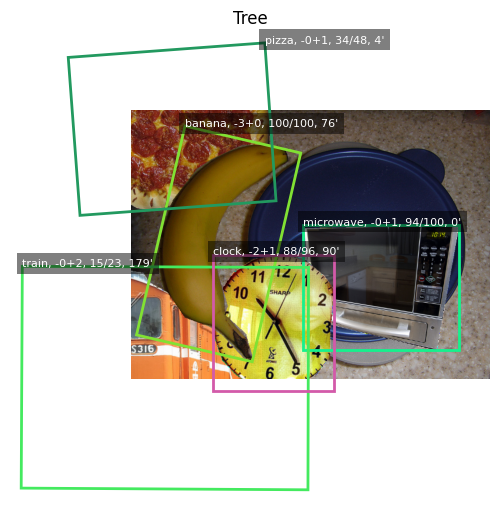

In [29]:
from COBB.codesV2 import Attach_destination, visible_annotations_with_captions, label_orientation, show_obbox, get_DAG, print_annotations

N_source_images=5
bbox_kind = 'obbox' #'bbox', 'obbox'

img_id_destination = random.sample(img_ids_list, 1)[0] #coco.getImgIds()[random.randint(0, 5000)]

print(f'img_id_destination={img_id_destination}')
img_path=coco.loadImgs(img_id_destination)[0]['coco_url']
I_destination = io.imread(img_path)

annotationsD = coco.loadAnns(coco.getAnnIds(imgIds=img_id_destination))
annotations_destination = remove_crowded(annotationsD)
Image_layers, Mask_layers, Added_annotations = generate_overlayed_frames(coco, I_destination,img_id_destination, N_source_images,
                                                                         img_ids_list =img_ids_list, margin_ratio=1, inContact_ratio_limit=1, with_unbounded_obbox=True)

I_projected, Image_layers,Mask_layers = Attach_destination(coco, I_destination,annotations_destination, Image_layers,Mask_layers, Added_annotations,img_id_destination, N_source_images)
#Stack_Order_Matrix = get_Stack_Order_Matrix(Mask_layers, IoU= True)
I_projected, Visible_annotations, Added_annotations_list, annotations_destination, objects_order, Stack_Order_Matrix_iou = overlay(coco, I_projected,annotations_destination,
                                                                                          Image_layers,Mask_layers, Added_annotations,
                                                                                          N_source_images, with_unbounded_obbox=True)
Visible_annotations =visible_annotations_with_captions(Visible_annotations)
Visible_annotations = label_orientation(Visible_annotations)

#Plot
I_plot = I_projected.copy()
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
#anns = BB_criterion(Visible_annotations, coco)#, standard_method='regular', floating_objects=[],Standing_objects=[], objects_with_axis=[])
show_obbox(I_plot, Visible_annotations, coco,bbox_key=bbox_kind, title='Tree', with_segment=False, with_arrow=True,with_category=True, ax=ax)

print('The label shown above an object: <object category, -No. objects behind it, +No. objects over it , visibile area%, /, visible area% due to cut only, orientation >')

{1: ['microwave'], 2: ['train'], 3: ['clock'], 4: ['pizza'], 5: ['banana']} 
 [[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


({'microwave': ['clock'],
  'train': ['clock', 'banana'],
  'clock': ['banana'],
  'pizza': ['banana'],
  'banana': []},
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

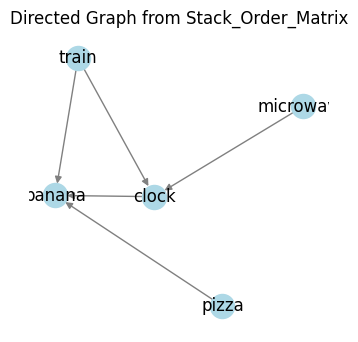

In [30]:
Stack_Order_Matrix = (Stack_Order_Matrix_iou>0)+0
print(objects_order,'\n' ,Stack_Order_Matrix)

get_DAG(Stack_Order_Matrix, objects_order, plot = True )

In [31]:
print_annotations(Visible_annotations)

[
{
"segmentation": [[205.55,447.25,217.98,442.73,208.94,414.49,205.55,399.81,167.15,364.8,172.8,350.12,161.51,310.59,150.21,268.8,151.34,224.75,161.51,194.26,164.89,184.09,195.39,151.34,225.88,128.75,263.15,107.29,280.09,89.22,280.09,76.8,267.67,67.76,241.69,62.12,198.78,62.12,144.56,86.96,117.46,105.04,75.67,159.25,55.34,202.16,49.69,246.21,59.86,317.36,96.0,370.45,141.18,387.39,162.64,402.07,195.39,437.08,202.16,444.99]],
"area": 35877.4084,
"iscrowd": 0,
"image_id": 290619,
"bbox": [49.69,62.12,230.4,385.13],
"category_id": 52,
"id": 1045668,
"Visible_due2_overlay": 100,
"Visible_due2_cut": 100,
"Visible": 100,
"Layer": -1,
"category": "banana",
"N_obj_behind": 3,
"N_obj_over": 0,
"obbox": [215.5,448.4,8.9,400.5,95.5,27.6,302.1,75.6],
"orientation": 76
},
{
"segmentation": [[567,204,566,205,540,205,539,206,488,206,487,207,462,207,461,208,410,208,409,209,383,209,382,210,331,210,330,211,307,211,308,212,308,217,309,218,309,228,310,229,310,234,311,235,311,244,312,245,312,250,313,251,31

## Augmented regular bounding boxes


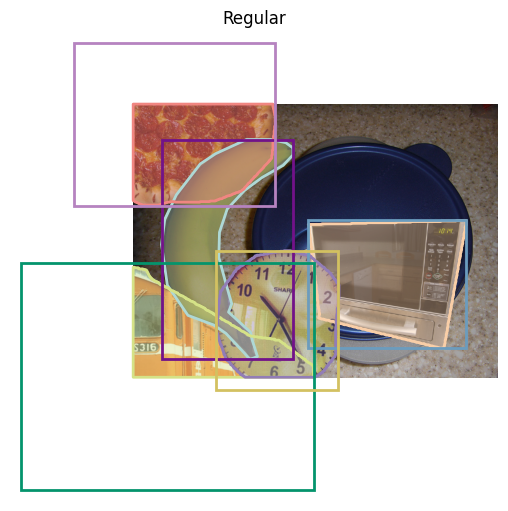

In [33]:
bbox_kind = 'bbox' #'bbox', 'obbox'

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
#anns = BB_criterion(Visible_annotations, coco)#, standard_method='regular', floating_objects=[],Standing_objects=[], objects_with_axis=[])
show_obbox(I_plot, Visible_annotations, coco,bbox_key=bbox_kind, title='Regular', with_segment=True, with_arrow=False,with_category=False, ax=ax)

## Save annotations

In [34]:
from COBB.codesV2 import save_annotations_json, read_annotations_json

#save json
save_folder = '/content/'
file_path = save_folder +'anns1948'

Overlay = {
    'objects_order': objects_order,
    'Stack_Order_Matrix_iou': Stack_Order_Matrix_iou.tolist(),
    'Stack_Order_Matrix': Stack_Order_Matrix.tolist(),
}

save_annotations_json(Visible_annotations,Overlay, file_path+'.json')
#anns_loaded= read_annotations_json(file_path)

#save image
io.imsave(file_path + '.png', I_plot)

In [35]:
ann_read = read_annotations_json(file_path+'.json')
overlaymap_read = read_annotations_json(file_path+'_overlaymap.json')

# OBB - No Augmentation

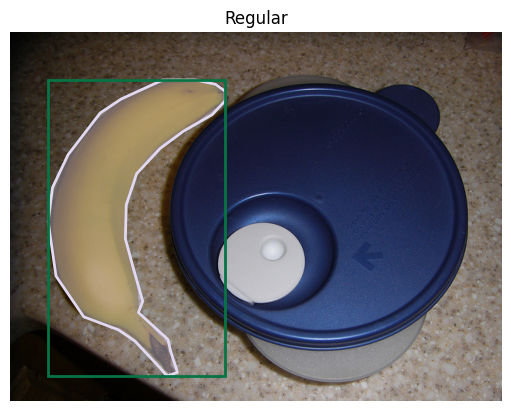

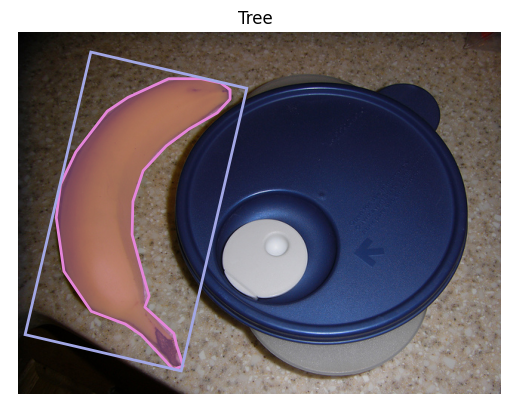

In [43]:
# Example usage for plotting multiple images horizontally
select_random_img = False

if select_random_img:
  img_id = coco.getImgIds()[random.randint(0, 5000)]  # Replace with your desired image ID
  print(f'img_id={img_id}')
else:
  img_id = img_id_destination

img_path=coco.loadImgs(img_id)[0]['coco_url']
annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
I = io.imread(img_path)
I_plot = I.copy()

#----- show rectangular bounding boxes ------------------
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
anns = BB_criterion(annotations, coco)#, standard_method='regular', floating_objects=[],
                    #Standing_objects=[], objects_with_axis=[])
show_obbox(I_plot, anns, coco, title='Regular', with_segment=True, with_arrow=False,with_category=False, ax=ax)

#----- show oriented bounding boxes ------------------
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
anns = BB_criterion(annotations, coco, standard_method= 'PCA',
                    floating_objects=MethodsLists['rotating_calipers'],
                    Standing_objects=MethodsLists['regular'], objects_with_axis=MethodsLists['PCA'])
show_obbox(I_plot, anns, coco, title='Tree', with_segment=True, with_arrow=False,with_category=False, ax=ax)

# Compare OBB methods

img_id=290619


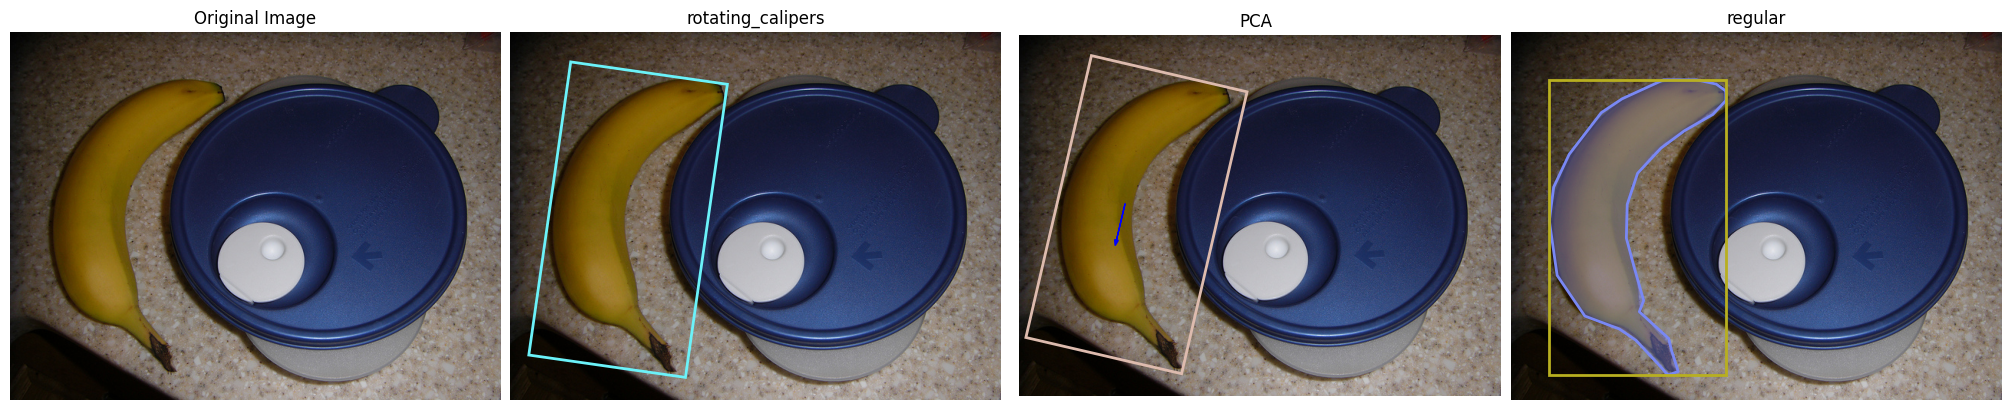

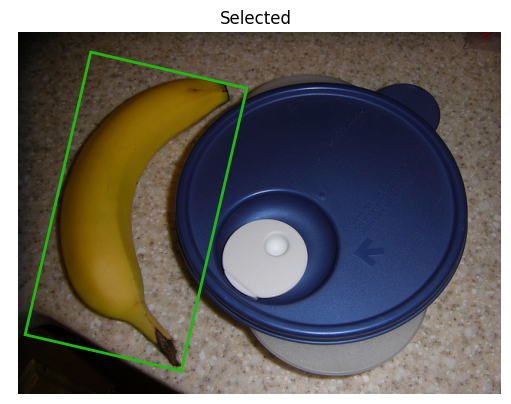

In [40]:
select_random_img = False

if select_random_img:
  img_id = coco.getImgIds()[random.randint(0, 5000)]  # Replace with your desired image ID
else:
  img_id = img_id_destination

print(f'img_id={img_id}')

img_path=coco.loadImgs(img_id)[0]['coco_url']
annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
I = io.imread(img_path)
I_plot = I.copy()

fig, axes = plt.subplots(1, len(methods) + 1, figsize=(5 * (len(methods) + 1), 5), constrained_layout=True)
# Plot original image first
axes[0].imshow(I_plot)
axes[0].axis('off')
axes[0].set_title("Original Image")
for i, standard_method in enumerate(methods):
    anns = BB_criterion(annotations, coco, standard_method, floating_objects=[], Standing_objects=[], objects_with_axis=[])
    show_obbox(I_plot, anns, coco, title=standard_method,
               with_segment=standard_method == 'regular',
               with_arrow=(standard_method == 'PCA'),
               with_category=False, ax=axes[i + 1])

#plot
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
anns = BB_criterion(annotations,coco, standard_method= 'PCA', floating_objects=MethodsLists['rotating_calipers'],
                    Standing_objects=MethodsLists['regular'], objects_with_axis=MethodsLists['PCA'])
show_obbox(I_plot, anns, coco, title='Selected', with_segment=False, with_arrow=False,with_category=False, ax=ax)
plt.show()

# Source code

In [ ]:
from pycocotools.coco import COCO
import cv2
import json
import tqdm
import glob
import pylab
import random
import numpy as np
import networkx as nx
import skimage.io as io
from collections import Counter
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.decomposition import PCA
from shapely.geometry.polygon import orient
from shapely.validation import explain_validity
from scipy.ndimage import binary_dilation, convolve
from matplotlib.patches import Polygon as MatplotlibPolygon

pylab.rcParams['figure.figsize'] = (4.0, 6.0)

MethodsLists = {
    "rotating_calipers":[ "cat", "dog","bed"], #short_objects_captued_oriented,
    "PCA": [ "person", "bicycle", "motorcycle","train", "umbrella", "bird",] ,
    "regular": ["bus","traffic light","horse", "sheep", "cow", "elephant", "bear",
                "zebra", "giraffe", "chair", "couch","potted plant",  "clock","vase",
                "teddy bear","car","refrigerator","truck","microwave", "oven", "tv"], }

# Function to calculate rotated rectangles using rotating calipers
def rotating_calipers_rectangles(hull):
    rectangles = []
    hull_points = hull[:, 0, :]
    n = len(hull_points)
    max_length = 0
    for i in range(n):
        # Get the edge formed by two consecutive points
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % n]
        # Compute the edge vector and angle of rotation
        edge_vector = p2 - p1
        edge_length = np.linalg.norm(edge_vector)
        edge_angle = np.arctan2(edge_vector[1], edge_vector[0])
        # Rotate the hull points to align the edge with the x-axis
        rotation_matrix = np.array([[-np.cos(edge_angle), np.sin(edge_angle)],
                                     [-np.sin(edge_angle),  -np.cos(edge_angle)]])
        rotated_points = np.dot(hull_points - p1, rotation_matrix.T)
        # Get the bounding box of the rotated points
        x_min, y_min = np.min(rotated_points, axis=0)
        x_max, y_max = np.max(rotated_points, axis=0)
        # Calculate the rectangle corners in the original coordinate system
        rectangle = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        rectangle = np.dot(rectangle, rotation_matrix) + p1
        rectangles.append(rectangle)
        if edge_length>max_length:
          max_length = edge_length
          rect_aligned_with_maxEdge = rectangle
    return rectangles, rect_aligned_with_maxEdge

def intersection_area(rect1: np.ndarray, rect2: np.ndarray, plot=False) -> float:
    """
    Calculate the intersection area of two rectangles (possibly rotated).
    :param rect1: numpy array of shape (4, 2) representing the first rectangle
    :param rect2: numpy array of shape (4, 2) representing the second rectangle
    :return: The intersection area (float). Returns 0 if no intersection.
    """
    def validate_polygon(coords):
        """Validates and fixes a polygon if necessary."""
        polygon = Polygon(coords)
        if not polygon.is_valid:
            print(f"Invalid polygon: {explain_validity(polygon)}")
            # Attempt to fix self-intersection by using the convex hull
            polygon = polygon.convex_hull
            print(f"Polygon fixed using convex hull: {polygon.wkt}")
        # Ensure the polygon is oriented counterclockwise
        return orient(polygon, sign=1.0)
    # Validate and fix input polygons
    poly1 = validate_polygon(rect1)
    poly2 = validate_polygon(rect2)
    # Find the intersection of the two polygons
    intersection = poly1.intersection(poly2)
    # Plotting
    if plot:
        fig, ax = plt.subplots(figsize=(3,3))
        # Add rectangles
        rect_patch1 = MatplotlibPolygon(np.array(poly1.exterior.coords), closed=True, edgecolor='blue', facecolor='blue', alpha=0.4)#, label="p1")
        rect_patch2 = MatplotlibPolygon(np.array(poly2.exterior.coords), closed=True, edgecolor='green', facecolor='green', alpha=0.4)#, label="p2")
        ax.add_patch(rect_patch1)
        ax.add_patch(rect_patch2)
        # Add intersection if it exists
        '''if not intersection.is_empty and isinstance(intersection, ShapelyPolygon):
            x, y = intersection.exterior.xy
            ax.fill(x, y, color='red', alpha=0.5, label="Intersection")'''
        # Adjust plot limits
        all_points = np.vstack((rect1, rect2))
        x_min, y_min = all_points.min(axis=0)
        x_max, y_max = all_points.max(axis=0)
        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_ylim(y_min - 1, y_max + 1)
        ax.set_aspect('equal', adjustable='box')
        # Add legend and labels
        ax.legend()
        #ax.set_title("Rectangle Intersection")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plt.grid(True)
        plt.show()
    # Calculate the area of the intersection
    if intersection.is_empty:
        return 0.0  # No intersection
    return intersection.area

def rle_to_mask(rle):
    """
    Converts Run-Length Encoding (RLE) to a binary segmentation mask.
    Args:
        rle (dict): A dictionary containing:
            - 'counts': The RLE as a list or string (COCO format).
            - 'size': A list or tuple with the dimensions [height, width].
        shape (tuple): The shape of the mask (height, width).
    Returns:
        np.ndarray: A binary mask of the given shape (height, width).
    """
    # Extract RLE counts and mask size
    counts = rle['counts']
    height, width = rle['size']
    # If counts are in string format, split and convert to integers
    if isinstance(counts, str):
        counts = list(map(int, counts.split()))
    # Flatten the RLE counts into a binary array
    mask = np.zeros(height * width, dtype=np.uint8)
    start = 0  # Start position in the flattened mask
    for i, length in enumerate(counts):
        if i % 2 == 1:  # Foreground (object) pixels
            mask[start:start + length] = 1
        # Move the starting point forward
        start += length
    # Reshape the flat mask into the specified 2D shape
    return mask.reshape((width, height))

def find_main_axis(mask):
    # Get the coordinates of the object (where mask == 1)
    y, x = np.where(mask == 1)
    points = np.column_stack((x, y))
    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(points)
    # Principal axis (first component)
    center = np.mean(points, axis=0)
    direction = pca.components_[0]
    return center, direction

def oriented_bbox(mask, direction_vector, center):
    rectangles = []
    hull_points = np.column_stack(np.where(mask > 0))#hull[:, 0, :]
    angle = np.arctan(direction_vector[1]/(direction_vector[0]+0.00000001))
    # Rotate the hull points to align the edge with the x-axis
    rotation_matrix = np.array([[-np.cos(angle), np.sin(angle)],
                                  [-np.sin(angle),  -np.cos(angle)]])
    rotated_points = np.dot(hull_points - center, rotation_matrix.T)
    # Get the bounding box of the rotated points
    x_min, y_min = np.min(rotated_points, axis=0)
    x_max, y_max = np.max(rotated_points, axis=0)
    # Calculate the rectangle corners in the original coordinate system
    rectangle = np.array([
        [x_min, y_min],
        [x_max, y_min],
        [x_max, y_max],
        [x_min, y_max]
    ])
    rectangle = np.dot(rectangle, rotation_matrix) + center
    return rectangle


def annotation_2_category(annotation, coco):
  category_id = annotation['category_id']
  categories = coco.loadCats(category_id)
  if categories:
      return categories[0]['name']  # Return the name of the category
  else:
      return "NA"

def annotation_items(annotation, coco):
  image_id = annotation['image_id']
  image_info = coco.loadImgs(image_id)[0]
  image_height = image_info['height']
  image_width = image_info['width']
  object_name = annotation_2_category(annotation, coco)
  segmnt = annotation['segmentation']
  if annotation['iscrowd']== 0:
    polygons_lists = segmnt
    flattened_list = [item for sublist in polygons_lists for item in sublist]
    hull = np.array(flattened_list).reshape([-1,1,2])
    #hull = cv2.convexHull(hull.astype(np.int32))
    mask = np.zeros([image_height, image_width])
    cv2.fillPoly(mask, [hull.astype(np.int32)],1)
    mask = mask.T
  else:
    mask = rle_to_mask(segmnt)
    # Find all non-zero points in the mask
    segmented_points = np.column_stack(np.where(mask > 0))
    if len(segmented_points) == 0:
        raise ValueError("No object found in the segmentation mask.")
    # Compute the convex hull of all points
    hull = cv2.convexHull(segmented_points)
    #mask = mask
  return hull, image_width, image_height, object_name, mask

def get_OBB(annotation, coco, method='regular', plot=False):
  #method = ['regular', 'PCA', 'rotating_calipers','logest_edge']
  #flattened_list = [item for sublist in polygons_lists for item in sublist]
  #hull = np.array(flattened_list).reshape([-1,1,2])
  hull, image_width, image_height, object_name, mask = annotation_items(annotation, coco)
  rectangles, rect_aligned_with_maxEdge = rotating_calipers_rectangles(hull)

  if  method == 'rotating_calipers':
    image_rectangle = np.array([[0,0],[image_width,0],[image_width, image_height],[0,image_height]])
    #image_rectangle = np.array([[0,0],[image_height,0],[image_height, image_width],[0,image_width]])
    min_area = np.inf
    for i, rect in enumerate(rectangles):
      area = intersection_area(image_rectangle, rect,plot=plot)
      if area<min_area:
        min_area = area
        selected_box = rect
  elif  method == 'regular':
    x_min, y_min, width, height = annotation['bbox']
    x_max, y_max = x_min + width, y_min + height
    selected_box = np.array([[x_min, y_min],
                              [x_max, y_min],
                              [x_max, y_max],
                              [x_min, y_max]])
  elif  method == 'logest_edge':
    selected_box = rect_aligned_with_maxEdge
  elif method == 'PCA':
    center, direction = find_main_axis(mask)
    selected_box = oriented_bbox(mask, direction, center)
    annotation['center']= list(map(float,np.round(center,2)))#center
    annotation['direction']= list(map(float,np.round(direction,2)))#direction
  return selected_box


def BB_criterion_selection(category, standard_method= 'PCA',floating_objects=MethodsLists['rotating_calipers'],Standing_objects=MethodsLists['regular'], objects_with_axis=MethodsLists['PCA']):
  #All_objects = floating_objects+Standing_objects+objects_with_axis
  if standard_method != 'None':
      #method = ['None', 'regular', 'PCA', 'rotating_calipers','logest_edge']
      if category in Standing_objects:
        method = 'regular'#'regular'
      elif category in objects_with_axis:
        method = 'PCA'
      elif category in floating_objects:
        method = 'rotating_calipers'#'rotating_calipers'
      else:
        method = standard_method
  return method

def BB_criterion(annotations, coco, standard_method='regular',floating_objects=[], Standing_objects=[],objects_with_axis=[]):
  #All_objects = floating_objects+Standing_objects+objects_with_axis
  if standard_method != 'None':
    for annotation in annotations:
      category = annotation_2_category(annotation, coco)
      method = BB_criterion_selection(category,standard_method,floating_objects, Standing_objects,objects_with_axis)
      #print(category)
      #method = ['None', 'regular', 'PCA', 'rotating_calipers','logest_edge']
      selected_box=get_OBB(annotation, coco, method=method)
      annotation['obbox'] = list(map(float, np.round(selected_box, 1).reshape(-1)))#list(np.round(selected_box,1).reshape(-1))
  return annotations

def remove_crowded(annotations):
  annotations_after = []
  for ann in annotations:
    if ann['iscrowd'] == 0:
      annotations_after.append(ann)
  return annotations_after

def coco_bbox_to_coords(bbox):
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    return x_min, y_min, x_max, y_max

def Is_within_boundaries(ann, img_info, margin_ratio=0.1):
  img_height = img_info['height']
  img_width = img_info['width']
  x_min, y_min, x_max, y_max = coco_bbox_to_coords(ann['bbox'])
  c1 = x_min> (margin_ratio)*img_width
  c2 = y_min> (margin_ratio)*img_height
  c3 = x_max< (1-margin_ratio)*img_width
  c4 = y_max< (1-margin_ratio)*img_height
  within_bounaries = (c1 and c2) and (c3 and c4)
  return within_bounaries

def remove_beyond_boudaries(annotations,img_info, margin_ratio=0.1):
  annotations_after = []
  for ann in annotations:
    if Is_within_boundaries(ann, img_info, margin_ratio):
      annotations_after.append(ann)
  return annotations_after

def get_segmentation_mask(anns,img_info, coco):
    image_size = (img_info['height'],  img_info['width'])
    # Initialize an empty mask
    Full_mask = np.zeros(image_size, dtype=np.uint8)
    for ann in anns:
        if 'segmentation' in ann:
            # Convert segmentation to mask
            mask_1obj = coco.annToMask(ann)
            #hull, image_width, image_height, object_name, mask_1obj = annotation_items(ann, coco)
            Full_mask = Full_mask + mask_1obj  # Combine masks
    return Full_mask

def compute_inContact_ratio(object_mask, all_objects_mask):
    """
    Computes the overlap ratio of the perimeter of object1 with other objects.
    Parameters:
    - object_mask: 2D numpy array (binary) representing the single object mask.
    - all_objects_mask: 2D numpy array (binary) representing all objects in the scene.
    Returns:
    - Overlap ratio (float)
    """
    # Define a 3x3 structuring element for detecting the perimeter
    struct_elem = np.ones([7,7])
    # Compute the perimeter of object1
    dilated_object = binary_dilation(object_mask, structure=struct_elem)
    perimeter = dilated_object & ~object_mask
    # Compute the overlapping pixels by checking if perimeter pixels touch other objects
    inContact_pixels = perimeter & (all_objects_mask & ~object_mask)
    # Compute overlap ratio
    perimeter_count = np.sum(perimeter)
    inContact_count = np.sum(inContact_pixels)
    return inContact_count / perimeter_count if perimeter_count > 0 else 0

def remove_inContact(coco, annotations, Full_mask, inContact_ratio_limit = 0.15):
  annotations_cleaned = []
  for ann in annotations:
    if 'segmentation' in ann:
      object_mask = coco.annToMask(ann)
      inContact = compute_inContact_ratio(object_mask, Full_mask)
      ann['inContact'] = inContact
      if (inContact<inContact_ratio_limit) or (inContact>0.95):
        annotations_cleaned.append(ann)
  return annotations_cleaned

def apply_transformation(image,mask, angle=0, scale=1, tx=0, ty=0):
    height, width = image.shape[:2]
    # Compute the transformation matrix
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    M[0, 2] += tx
    M[1, 2] += ty
    # Apply transformation
    transformed_image = cv2.warpAffine(image, M, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    transformed_mask = cv2.warpAffine(mask, M, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return transformed_image,transformed_mask, M

def compute_coco_bbox(mask):
    y_indices, x_indices = np.where(mask > 0)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None  # No object found after transformation
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    return [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]

def compute_VisibleArea(original_mask, transformed_mask, scale):
    original_pixels = np.sum(original_mask > 0)
    transformed_pixels = np.sum(transformed_mask > 0)
    if original_pixels == 0:
        return 0  # Avoid division by zero if the original mask has no object
    Area_loss = transformed_pixels/((scale**2)*original_pixels)
    return min(int(Area_loss*100), 100)

def mask_to_coco_annotation(binary_mask):
    binary_mask = (binary_mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten().tolist()
        if len(contour) > 4: # coco needs at least 3 points
            segmentation.append(contour)
    if not segmentation:
        return None # return none if no valid contour is found.
    x, y, w, h = cv2.boundingRect(binary_mask)
    bbox = [x, y, w, h]
    area = int(cv2.contourArea(contours[0])) #calculate area.
    return segmentation, bbox, area

def copy_paste_augmentation(coco, annotations_source_cleaned,I_source,I_destination, img_id_destination, with_unbounded_obbox=True):
  h0,w0,d0 = I_destination.shape
  Total_number_objects = len(annotations_source_cleaned)
  if Total_number_objects>0:
    selected_object = np.random.randint(Total_number_objects)
    ann_1obj = annotations_source_cleaned[selected_object]#random.choice(annotations_source_cleaned)
    mask_1obj = coco.annToMask(ann_1obj)
    Img_1obj = I_source * mask_1obj[:, :, np.newaxis]
    xmin, ymin, w, h = ann_1obj['bbox']
    if h>h0 or w>w0:
      #scale image and mask if the size of the object is larger than that of the
      Img_1obj = cv2.resize(Img_1obj, (w0//2, h0//2))
      mask_1obj = (np.sum(Img_1obj,axis=-1)>0).astype(np.uint8)
    xmin, ymin, w, h =compute_coco_bbox(mask_1obj)
    h = int(h)
    w = int(w)
    # place it at the center of the destination image
    #first find the object cooridntaes in the source
    ymin_src = max(int(ymin), 0)
    xmin_scr = max(int(xmin),0)
    ymax_scr = ymin_src + h
    xmax_src = xmin_scr + w
    #secod find where to place it to be in the center
    ymin_dist = max(int((h0-h)//2), 0)
    xmin_dist = max(int((w0-w)//2),0)
    ymax_dist = min(ymin_dist + h,h0)
    xmax_dist = min(xmin_dist + w, w0)
    # place object in the center
    Img_cenetred = np.zeros([h0,w0,3])#np.zeros_like(I_destination)
    Mask_cenetred = np.zeros([h0,w0])
    Img_cenetred[ymin_dist:ymax_dist, xmin_dist:xmax_dist, :] = Img_1obj[ymin_src:ymax_scr, xmin_scr:xmax_src,:].astype(np.uint8)
    Mask_cenetred[ymin_dist:ymax_dist, xmin_dist:xmax_dist] = mask_1obj[ymin_src:ymax_scr, xmin_scr:xmax_src]
    # Augment the image
    angle = 0#if you use rotation, the bbox will be bounded within the image boundary.
    scale = np.random.uniform(0.5, 1.25)#np.random.uniform(0.5, 1.25)
    ty = np.random.uniform(-0.5, 0.5) * h0
    tx = np.random.uniform(-0.5, 0.5) * w0
    #print(scale)
    augmented_image,augmented_mask,M = apply_transformation(Img_cenetred,Mask_cenetred, angle, scale, tx, ty)
    # create new annotation
    visible_area_image = compute_VisibleArea(Mask_cenetred, augmented_mask, scale)
    #print(visible_area_image)
    segmentation, bbox, area = mask_to_coco_annotation(augmented_mask)
    # if full bbox is known there is a better way to calculate the dimensions, without being limited to boundaries
    if angle==0:
      #x, y, w, h = bbox
      #h0,w0,d0 = Img_cenetred.shape
      #ymin_dist = max(int((h0-h)//2), 0)
      #xmin_dist = max(int((w0-w)//2),0)
      obj_bbox = [xmin_dist,ymin_dist,w, h]
      bbox=transform_bbox(obj_bbox, M)
      '''
      #full bounding box boundaries
      bbx_ymin = int(ty+ (scale)*(ymin_dist-h0//2)+h0//2)
      bbx_xmin = int(tx + (scale)*(xmin_dist-w0//2)+w0//2)
      #bbx_ymax = bbx_ymin + h
      #bbx_xmax = bbx_xmin + w
      bbx_h = scale*h
      bbx_w = scale*w
      bbox = [bbx_xmin,bbx_ymin,bbx_w,bbx_h]'''
    category = annotation_2_category(ann_1obj, coco)
    New_annotation = {'segmentation': [list(map(int, segment)) for segment in segmentation],
        'iscrowd':ann_1obj['iscrowd'],
        'image_id': img_id_destination, # the negative sign to distingush it from the origional image
        'category_id':ann_1obj['category_id'], 'id':ann_1obj['id'], #'inContact':ann_1obj['inContact'],
        'category': category,
        'source_image_id':ann_1obj['image_id'], 'isAugmented':1,
        'area': area,'bbox': bbox,'Visible_due2_cut':visible_area_image, }
    if with_unbounded_obbox:
      obbox1 = mask_to_obbox(binary_mask=Mask_cenetred, category=category)
      New_annotation['obbox'] = transform_obbox(obbox1, M)
  else:
    print('No objects to augment')
  return augmented_image,augmented_mask, New_annotation


def transform_bbox(bbox, M):
    """
    Transforms a COCO-format bounding box using the affine transformation matrix M.
    :param bbox: Bounding box in COCO format [x, y, width, height]
    :param M: 2x3 affine transformation matrix
    :return: Transformed bounding box in COCO format [x', y', w', h']
    """
    x1, y1, w, h = bbox
    x = x1
    y = y1
    # Define the four corner points of the bounding box
    corners = np.array([
        [x, y, 1],        # Top-left
        [x + w, y, 1],    # Top-right
        [x, y + h, 1],    # Bottom-left
        [x + w, y + h, 1] # Bottom-right
    ])  # Shape (n,3)
    # Apply the affine transformation
    transformed_corners = np.dot(M, corners.T)  # Shape (2,4)
    #print(transformed_corners.shape)
    # Extract new bounding box coordinates
    x_min, y_min = transformed_corners[:,0].T#transformed_corners.min(axis=1)
    x_max, y_max = transformed_corners[:,-1].T#transformed_corners.max(axis=1)
    # Compute new width and height
    new_w = x_max - x_min
    new_h = y_max - y_min
    new_x_min = x_min
    new_y_min = y_min
    return [int(new_x_min), int(new_y_min), int(new_w), int(new_h)]


def transform_obbox(obbox, M):
    x1, y1, x2, y2, x3,y3,x4,y4 = obbox
    # Define the four corner points of the bounding box
    coords = np.array([[x1, y1, 1], [x2, y2, 1], [x3, y3, 1], [x4, y4, 1]])  # Shape (n,3)
    # Apply the affine transformation
    transformed_corners = np.dot(M, coords.T)  # Shape (2,4)
    #print(transformed_corners.shape)
    # Extract new bounding box coordinates
    new_x1, new_y1 = transformed_corners[:,0].T
    new_x2, new_y2 = transformed_corners[:,1].T
    new_x3, new_y3 = transformed_corners[:,2].T
    new_x4, new_y4 = transformed_corners[:,3].T
    new_obbox = [int(new_x1),int(new_y1),int(new_x2),int(new_y2),int(new_x3),int(new_y3),int(new_x4),int(new_y4)]
    return new_obbox

def mask_to_obbox(binary_mask, category):
  method = BB_criterion_selection(category)
  mask = binary_mask>0
  segmentation, bbox, area=mask_to_coco_annotation(mask)
  flattened_list = [item for sublist in segmentation for item in sublist]
  hull = np.array(flattened_list).reshape([-1,1,2])
  rectangles, rect_aligned_with_maxEdge = rotating_calipers_rectangles(hull)
  if  method == 'rotating_calipers':
    # double check
    image_width, image_height = mask.shape
    image_rectangle = np.array([[0,0],[image_width,0],[image_width, image_height],[0,image_height]])
    #image_rectangle = np.array([[0,0],[image_height,0],[image_height, image_width],[0,image_width]])
    min_area = np.inf
    for i, rect in enumerate(rectangles):
      area = intersection_area(image_rectangle, rect,plot=False)
      if area<min_area:
        min_area = area
        selected_box = rect
  elif  method == 'regular':
    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height
    selected_box = np.array([[x_min, y_min],
                              [x_max, y_min],
                              [x_max, y_max],
                              [x_min, y_max]])
  elif  method == 'logest_edge':
    selected_box = rect_aligned_with_maxEdge
  elif method == 'PCA':
    mask = binary_mask.T>0
    center, direction = find_main_axis(mask)
    selected_box = oriented_bbox(mask, direction, center)
    #annotation['center']= list(map(float,np.round(center,2)))#center
    #annotation['direction']= list(map(float,np.round(direction,2)))#direction
  obbox=list(map(float, np.round(selected_box, 1).reshape(-1)))
  return obbox

def calculate_visibility(Current_mask,Overlaying_mask):
    Current_mask = Current_mask>0
    Overlaying_mask = Overlaying_mask>0
    Overlap = np.multiply(Overlaying_mask, Current_mask)>0
    Visibility = 100*np.round(1 - (np.sum(Overlap)/np.sum(Current_mask)),2) if np.sum(Current_mask)>0 else 0
    return min(int(Visibility), 100)

def Check_bboxes_intersect(bbox1, bbox2):
    """
    Check if two COCO-format bounding boxes intersect.
    COCO bounding box format: [x, y, width, height]
    Args:
        bbox1 (list or tuple): [x1, y1, w1, h1] for the first bbox
        bbox2 (list or tuple): [x2, y2, w2, h2] for the second bbox
    Returns:
        bool: True if the bounding boxes intersect, False otherwise.
    """
    x1_min, y1_min, w1, h1 = bbox1
    x2_min, y2_min, w2, h2 = bbox2
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_max, y2_max = x2_min + w2, y2_min + h2
    # Check if there is an overlap
    if x1_min < x2_max and x1_max > x2_min and y1_min < y2_max and y1_max > y2_min:
        return True
    return False

def visible_annotations_with_captions(annotations):
  visible_annotations=[]
  for ann in annotations:
    if 'category_id' in ann:
      if 'Visible_due2_overlay' in ann:
        if ann['Visible_due2_overlay']>1:
          visible_annotations.append(ann)
  return visible_annotations

def generate_overlayed_frames(coco, I_destination,img_id_destination, N_source_images,img_ids_list = [], margin_ratio=1, inContact_ratio_limit=1, with_unbounded_obbox=True):
  h0,w0,d0 = I_destination.shape
  if len(img_ids_list)>0:
    Img_id_sources = random.sample(img_ids_list, N_source_images) #random.sample(coco.getImgIds(), N_source_images)
  else:
    Img_id_sources = random.sample(coco.getImgIds(), N_source_images)
  Image_layers = np.zeros([N_source_images+1, h0,w0, d0])
  Mask_layers = np.zeros([N_source_images+1, h0, w0])
  Added_annotations ={}
  for i in range(N_source_images):
    Img_id_source = Img_id_sources[i]
    img_info_source = coco.loadImgs(Img_id_source)[0]
    img_path_source = img_info_source['coco_url']
    I_source = io.imread(img_path_source)
    annotations_source = coco.loadAnns(coco.getAnnIds(imgIds=Img_id_source))
    # Filter the annotations: remove crowded objects
    annotations_source_cleaned = remove_crowded(annotations_source)
    # Filter the annotations: remove objects in contact with other objects
    Full_mask = get_segmentation_mask(annotations_source,img_info_source, coco)
    if inContact_ratio_limit<1:
      annotations_source_cleaned = remove_inContact(coco, annotations_source, Full_mask, inContact_ratio_limit)
    #Filter the annotations: remove objects beyond boundaries
    if margin_ratio<1:
      annotations_source_cleaned = remove_beyond_boudaries(annotations_source_cleaned,img_info_source, margin_ratio)
    # Augment the selected object
    if len(annotations_source_cleaned)> 0:
      augmented_image,augmented_mask, New_annotation = copy_paste_augmentation(coco,annotations_source_cleaned,I_source,I_destination,img_id_destination, with_unbounded_obbox)
      Image_layers[i] = augmented_image
      Mask_layers[i] = augmented_mask.astype(np.uint8)
      New_annotation['Layer']=i #This is to indicate the closeness of the object to the camera [bigger N -> closer to camera: overlayed above other objects]
      Added_annotations[i]= New_annotation
    else:
      Added_annotations[i]= {}
      #print(f'Caution:no enough objects in source image {i}')
  return Image_layers,Mask_layers, Added_annotations


def Attach_destination(coco, I_destination,annotations_destination, Image_layers,Mask_layers, Added_annotations,img_id_destination, N_source_images=5 ):
  I_destination_t = I_destination.astype(np.uint8).copy()  # Initialize with zeros
  img_info_destination=coco.loadImgs(img_id_destination)[0]
  Destination_mask = get_segmentation_mask(annotations_destination,img_info_destination, coco)
  Foreground = np.multiply(I_destination_t,Destination_mask[:, :, np.newaxis])
  Background = I_destination_t - Foreground
  Background_mask = 1 - Destination_mask
  I_projected = Background
  Image_layers[N_source_images]= Foreground
  Mask_layers[N_source_images]= Destination_mask
  Image_layers = Image_layers.astype('float64')
  return I_projected, Image_layers,Mask_layers

def get_visible_objects(coco, Image_layers, Mask_layers,Added_annotations, N_source_images=5 ):
  Visible_annotations={}
  objects_order ={}
  for j in range(N_source_images):
    Overlaying_mask = np.sum(Mask_layers[j+1:],axis=0)
    Visibility_j = calculate_visibility(Current_mask=Mask_layers[j], Overlaying_mask = Overlaying_mask)
    Added_annotations[j]['Visible_due2_overlay'] = min(Visibility_j, 100)
    if 'Visible_due2_cut' in Added_annotations[j].keys():
      Added_annotations[j]['Visible'] = min(100, int(Visibility_j*Added_annotations[j]['Visible_due2_cut']/100) )
    else:
      Added_annotations[j]['Visible'] = min(100, int(Visibility_j) )
    # if the visibility is below than 5% then it will be ignored/removed
    if Added_annotations[j]['Visible'] > 5:
      Visible_annotations[j]= Added_annotations[j]
      Visible_annotations[j]['Layer'] = j
      Visible_annotations[j]['category'] = annotation_2_category(Added_annotations[j], coco)
      objects_order[j]= [Added_annotations[j]['category']]
    else:
      Mask_layers[j]=0
      Image_layers[j]=0
      #Visible_annotations[j]= {}#'Visible':0}
  return Image_layers, Mask_layers,Visible_annotations, objects_order


def overlay(coco, I_projected,annotations_destination, Image_layers,Mask_layers, Added_annotations, N_source_images=5,with_unbounded_obbox=False ):
  Image_layers, Mask_layers,Visible_annotations, objects_order = get_visible_objects(coco, Image_layers,
                                                                                     Mask_layers,Added_annotations,
                                                                                     N_source_images)
  Stack_Order_Matrix = get_Stack_Order_Matrix(Mask_layers, IoU= True)
  # loop through pasted objects
  for j in range(N_source_images+1):
    I_projected[Mask_layers[j] > 0] = 0  # Zero out pixels where the new object will be placed
    I_projected = np.add(I_projected, Image_layers[j]).astype(np.uint8)  # Place the new object
    if j in Visible_annotations.keys():
      Visible_annotations[j]['N_obj_behind'] = int(np.sum(Stack_Order_Matrix[:,j]>0))
      Visible_annotations[j]['N_obj_over'] = int(np.sum(Stack_Order_Matrix[j,:]>0))
    #except:
      #print(j)
    #Overlaying_mask = np.sum(Mask_layers[j+1:],axis=0)
    # showing a map of the number of objects overlaping in a pixel
    #Masks_behind = np.sum(Mask_layers[:j,:,:], axis=0)
    #if j< N_source_images:
      # Number of objects located behind and covered partially by the object of interest
      #Visible_annotations[j]['N_obj_behind'] =  np.max(np.multiply( Masks_behind, Mask_layers[j]))
    #print(Visibility[j])
  #Masks_behind_of_added_objects = (Masks_behind>0).astype(np.uint8)
  # loop through origional objects
  objects_order[N_source_images] =[]
  for dest_ann in annotations_destination:
    #dest_1obj_mask = coco.annToMask(dest_ann)#get_segmentation_mask(anns,img_info, coco)
    #VisibilityX = 100 #calculate_visibility(dest_1obj_mask, Overlaying_mask = Masks_behind_of_added_objects)
    dest_ann['Visible_due2_overlay']=100#int(min(VisibilityX,100))
    if 'Visible_due2_cut' in dest_ann.keys():
      dest_ann['Visible'] =dest_ann['Visible_due2_cut']
    else:
      dest_ann['Visible_due2_cut'] = 100
      dest_ann['Visible'] =100
    dest_ann['Layer']=-1
    category = annotation_2_category(dest_ann, coco)
    dest_ann['category'] = category
    dest_ann['N_obj_behind'] = int(np.sum(Stack_Order_Matrix[:,j]>0))
    dest_ann['N_obj_over'] = int(np.sum(Stack_Order_Matrix[j,:]>0))
    objects_order[N_source_images].append(dest_ann['category'])
    if with_unbounded_obbox:
      if 'segmentation' in dest_ann:
            binary_mask = coco.annToMask(dest_ann)
      '''method = BB_criterion_selection(category, standard_method= 'PCA',
                    floating_objects=MethodsLists['rotating_calipers'],
                    Standing_objects=MethodsLists['regular'], objects_with_axis=MethodsLists['PCA'])
      obbox1 = mask_to_obbox(binary_mask,method)#'regular')#'PCA','rotating_calipers')'''
      dest_ann['obbox'] = mask_to_obbox(binary_mask,category)
    #dest_ann['N_obj_behind']=np.max(np.multiply( Masks_behind_of_added_objects, dest_1obj_mask))
  # Merge annotations
  Added_annotations_list = list(Visible_annotations.values())
  #Added_annotations_list
  All_annotations_after_pasteAug = annotations_destination+Added_annotations_list
  #print(objects_order)
  return I_projected, All_annotations_after_pasteAug, Added_annotations_list, annotations_destination, objects_order, Stack_Order_Matrix


def percnt_to_str(num):
  return str(int(min(num,100)))

def show_obbox(I_plot, annotations, coco, title, bbox_key='obbox', with_segment=False, with_arrow=True, with_category=True, ax=None):
    I_plot = I_plot.astype(np.uint8)
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(I_plot)
    ax.axis('off')
    ax.set_title(title)
    if with_segment:
        plt.sca(ax)
        coco.showAnns(annotations, draw_bbox=False)
    all_x, all_y = [], []
    for annotation in annotations:
        coords = annotation[bbox_key]
        if len(coords) == 4:
            x1, y1, w, h = coords
            coords = [x1, y1, x1, y1 + h, x1 + w, y1 + h, x1 + w, y1]
        polygon_coords = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
        # Collect all x and y coordinates for axis adjustment
        all_x.extend([x for x, y in polygon_coords])
        all_y.extend([y for x, y in polygon_coords])
        mpl_patch = MatplotlibPolygon(polygon_coords, closed=True,
                                      edgecolor=[random.random() for _ in range(3)],
                                      facecolor="none", linewidth=2)
        ax.add_patch(mpl_patch)
        if with_arrow and 'center' in annotation:
            center = annotation['center']
            direction = annotation['direction']
            ax.arrow(center[1], center[0], direction[1] * 50, direction[0] * 50,
                     color='blue', head_width=5)
        if with_category:
            category_name = annotation_2_category(annotation, coco)
            show_text = category_name
            if 'N_obj_behind' in annotation.keys():
                show_text += (', -' + percnt_to_str(annotation['N_obj_behind']))
            if 'N_obj_over' in annotation.keys():
                show_text += ('+' + percnt_to_str(annotation['N_obj_over']))
            if 'Visible' in annotation.keys():
                show_text += (', ' + percnt_to_str(annotation['Visible']))
            if 'Visible_due2_cut' in annotation.keys():
                show_text += ('/' + percnt_to_str(annotation['Visible_due2_cut']))
            if 'orientation' in annotation.keys():
                show_text += (', ' + str(annotation['orientation'])+'\'')
            bbox_x, bbox_y = min(polygon_coords, key=lambda point: point[1])
            ax.text(bbox_x, bbox_y, show_text, color='white', fontsize=8,
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    # Adjust limits to include out-of-bound boxes
    img_h, img_w = I_plot.shape[:2]
    # Bounding box limits
    if all_x and all_y:
        margin = 20  # Extra space around bounding boxes
        min_x, max_x = min(all_x) - margin, max(all_x) + margin
        min_y, max_y = min(all_y) - margin, max(all_y) + margin
    else:
        min_x, max_x = 0, img_w
        min_y, max_y = 0, img_h
    # Ensure the full image is visible
    min_x = min(0, min_x)
    max_x = max(img_w, max_x)
    min_y = min(0, min_y)
    max_y = max(img_h, max_y)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.invert_yaxis()

def get_images_with_n_objects(coco, n):
    """
    Returns a list of image IDs that contain exactly `n` objects.
    :param coco_annotation_file: Path to the COCO annotation JSON file.
    :param n: Number of objects required in an image.
    :return: List of image IDs.
    """
    #coco = COCO(coco_annotation_file)
    # Count the number of objects per image
    image_object_count = Counter(ann["image_id"] for ann in coco.anns.values())
    # Return list of image IDs with exactly `n` objects
    return [image_id for image_id, count in image_object_count.items() if count == n]

def filter_image_id_beyond_boundaries(coco, imgs_with_n_obj, margin_ratio = 0.05):
  img_ids_list=[]
  for img_id in imgs_with_n_obj:
    img_info = coco.loadImgs(img_id)[0]
    img_path= img_info['coco_url']
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    #Remove if beyond boundaries
    annotations_within_boundaries = remove_beyond_boudaries(annotations,img_info, margin_ratio)
    if len(annotations_within_boundaries):
      img_ids_list.append(img_id)
  return img_ids_list

def Do_masks_intersect(mask1, mask2):
  intersect_mask = np.multiply(mask1, mask2)
  return np.sum(intersect_mask)>0

def Intersection_Over_Union(mask1, mask2):
  intersect_mask = np.multiply(mask1, mask2)
  Intersction = np.sum(intersect_mask)
  if Intersction==0:
    return 0
  else:
    Union_mask = np.clip(np.add(mask1, mask2), 0,1)
    Union = np.sum(Union_mask)
    return np.round(Intersction/Union, 2)

def get_Stack_Order_Matrix(Mask_layers, IoU= False):
  N_layers = Mask_layers.shape[0]
  Stack_Order_Matrix = np.zeros([N_layers, N_layers])
  for k in range(Stack_Order_Matrix.shape[0]):
    for l in range(k+1, Stack_Order_Matrix.shape[0]):
      if IoU:
        Stack_Order_Matrix[k,l]=Intersection_Over_Union(Mask_layers[l], Mask_layers[k])
      else:
        if Do_masks_intersect(Mask_layers[l], Mask_layers[k]):
          Stack_Order_Matrix[k, l]= 1
  return Stack_Order_Matrix


def get_DAG(Stack_Order_Matrix, node_dict, plot = True ):
  # Track unique names to handle duplicates
  node_names = {}
  name_count = {}
  for key, value in node_dict.items():
      name = value[0]
      if name in name_count:
          name_count[name] += 1
          unique_name = f"{name}_{name_count[name]}"  # Ensure uniqueness
      else:
          name_count[name] = 1
          unique_name = name
      node_names[key] = unique_name
  # Create directed graph
  G = nx.DiGraph()
  # Add edges while ignoring nodes that are missing from node_dict
  num_nodes = Stack_Order_Matrix.shape[0]
  for i in range(num_nodes):
      if i not in node_names:  # Skip unnamed nodes
          continue
      for j in range(num_nodes):
          if j not in node_names:  # Skip unnamed nodes
              continue
          if Stack_Order_Matrix[i, j] == 1:
              G.add_edge(node_names[i], node_names[j])
  if plot:
    # Draw the graph
    plt.figure(figsize=(3, 3))
    pos = nx.spring_layout(G)  # Layout for better visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
    plt.title("Directed Graph from Stack_Order_Matrix")
    #plt.show()
  # Create adjacency dictionary
  adjacency_dict = {node: [] for node in node_names.values()}
  for i in range(num_nodes):
      if i not in node_names:  # Skip unnamed nodes
          continue
      for j in range(num_nodes):
          if j not in node_names:  # Skip unnamed nodes
              continue
          if Stack_Order_Matrix[i, j] == 1:
              adjacency_dict[node_names[i]].append(node_names[j])
  return adjacency_dict, plt

def print_annotations(data_list: list):
    formatted_items = []
    for data in data_list:
        formatted_lines = []
        for key, value in data.items():
            formatted_value = json.dumps(value, separators=(',', ':')) if isinstance(value, list) else json.dumps(value)
            formatted_lines.append(f'"{key}": {formatted_value}')
        formatted_items.append("{\n" + ",\n".join(formatted_lines) + "\n}")
    print("[\n" + ",\n".join(formatted_items) + "\n]")

def save_annotations_json(annotations, overlaymap=None, filepath='annotations.json'):
    # Ensure data is a list; if it's a single dictionary, convert it into a list
    data = annotations
    if isinstance(annotations, dict):
        data = [annotations]
    with open(filepath, 'w') as f:
        formatted_items = []
        for data_item in data:
            formatted_lines = []
            for key, value in data_item.items():
                formatted_value = json.dumps(value, separators=(',', ':')) if isinstance(value, list) else json.dumps(value)
                formatted_lines.append(f'"{key}": {formatted_value}')
            formatted_items.append("{\n" + ",\n".join(formatted_lines) + "\n}")
        #if isinstance(data0, dict):
          #f.write(",\n".join(formatted_items))
        #else:
        f.write("[\n" + ",\n".join(formatted_items) + "\n]")
    if overlaymap is not None:
      with open(filepath.replace(".json", "_overlaymap.json"), "w") as f:
        json.dump(overlaymap, f, indent=0)  # indent=1 for pretty formatting

def read_annotations_json(filename: str):
    with open(filename, 'r') as f:
        data = json.load(f)  # Parse the JSON content into Python objects
    return data

def rectangle_longest_edge_orientation(obbox):
  #def get_obbox_orientation(obbox):
  x1, y1, x2, y2, x3, y3, x4, y4 = obbox
  Arr = np.array([[x1, y1],[x2, y2],[ x3, y3],[x4, y4 ]])
  Arr1 = np.array([x1, y1])
  # find the distances between all points
  distance_between_points = np.sqrt(np.sum((Arr - Arr1)**2,axis=1))
  # The diagonal is the one of the longest distance, then there are 2 other edges,
  #rank the points based on their distance from point 1
  rank = np.argsort(-distance_between_points)
  #pick the point that has the second longest distance (which is equivalent to the longest edge)
  point_num = rank[1]
  point = Arr[point_num]
  xn , yn = point
  # calculate the slope after finding 2 points on the long edge of a rectangle
  angle_rad = np.arctan2(abs(yn - y1), xn - x1)
  # Convert to degrees
  angle_deg = int(angle_rad*180/3.14)
  return angle_deg

def label_orientation(annotations):
  for ann in annotations:
    try:
      category = ann['category']
    except:
      category = ann['category']
    if category in MethodsLists['regular']:
      obbox = ann['obbox']
      theta = rectangle_longest_edge_orientation(obbox)
    else:
      obbox = ann['obbox']
      theta = rectangle_longest_edge_orientation(obbox)
    ann['orientation'] = theta
  '''elif category in MethodsLists['PCA']:
      direction = ann['direction']
      center = ann['center']
      theta = np.arctan2(direction[1], direction[0]) * 180 / np.pi'''
  return annotations